In [1]:
import numpy as np
import math
from collections import deque
from src.utils.inference import *
from src.game.dynamics import *
import matplotlib.pyplot as plt
from src.game.tweny48 import Twenty48



device = "cuda" if torch.cuda.is_available() else "cpu"
device







A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/local/Cellar/python@3.10/3.10.16/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/local/Cellar/python@3.10/3.10.16/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/Eric/PycharmProjects/2048/.venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/Eric

'cpu'

In [2]:
def get_reward(current_state, next_state):
    current_max = np.max(current_state)
    next_max = np.max(next_state)
    reward = (math.log2(next_max) * 0.1)

    if next_max == current_max:
        reward = 0

    reward += len(empty(next_state)) - len(empty(current_state))

    return reward

In [3]:
def make_prediction(model: nn.Module, state: np.ndarray, input_neurons, device: str) -> torch.tensor:
    model.eval()
    state = one_hot_states([state], input_neurons, device)
    with torch.inference_mode():
        pred = model(state).to(device)
    return pred

In [4]:
class ReplayBuffer(deque):

    def __init__(self, capacity: int):
        super().__init__(maxlen=capacity)

    def push(self, transition):
        super().append(transition)

    def full(self) -> bool:
        return len(self) >= self.maxlen

    def sample(self, batch_size: int):
        return random.sample(self, batch_size)

In [5]:
def one_hot_states(states: list[np.ndarray], num_classes: int, device: str) -> torch.Tensor:
    states_logged = []

    for state in states:
        state_log = np.where(state == 0, 0, np.log2(state)).astype(np.int64)
        states_logged.append(state_log)

    states_tensor = torch.Tensor(np.array(states_logged)).long().to(device)

    return torch.nn.functional.one_hot(states_tensor, num_classes= num_classes).float().to(device).permute(0, 3, 1, 2)

In [6]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        d = out_channels // 4
        self.conv1 = nn.Conv2d(in_channels, d, 1, padding='same')
        self.conv2 = nn.Conv2d(in_channels, d, 2, padding='same')
        self.conv3 = nn.Conv2d(in_channels, d, 3, padding='same')
        self.conv4 = nn.Conv2d(in_channels, d, 4, padding='same')

    def forward(self, x):
        output1 = self.conv1(x)
        output2 = self.conv2(x)
        output3 = self.conv3(x)
        output4 = self.conv4(x)
        return torch.cat((output1, output2, output3, output4), dim=1)

class DQModelConvBlock(nn.Module):

    def __init__(self, input_neurons: int, hidden_neurons: tuple, output_neurons: int, state_size: int, dropout: float = 0.5):
        super().__init__()
        self.input_block = nn.Sequential(
            ConvBlock(in_channels= input_neurons,
                      out_channels= hidden_neurons[0]),
            nn.ReLU(),
        )


        self.hidden_blocks = nn.ModuleList()
        for i in range(1, len(hidden_neurons)):
            self.hidden_blocks.append(nn.Sequential(
               ConvBlock(in_channels= hidden_neurons[i-1],
                      out_channels= hidden_neurons[i]),
               nn.ReLU(),
            ))

        flattened_in_features = hidden_neurons[-1]*(state_size**2)
        flatten_out_features = hidden_neurons[-1] //2
        self.output_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=flattened_in_features,
                      out_features=flatten_out_features),
            nn.Dropout(dropout),
            nn.Linear(in_features=flatten_out_features,
                      out_features=output_neurons)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.input_block(x)
        for hidden_block in self.hidden_blocks:
            x = hidden_block(x)
        return self.output_block(x)

In [7]:
class DQModel(nn.Module):

    def __init__(self, input_neurons: int, hidden_neurons: tuple, output_neurons: int, state_size: int, dropout: float = 0.5):
        super().__init__()
        self.input_block = nn.Sequential(
            nn.Conv2d(in_channels= input_neurons,
                      out_channels= hidden_neurons[0],
                      kernel_size=3,
                      padding="same"),
            nn.BatchNorm2d(hidden_neurons[0]),
            nn.ReLU(),
        )


        self.hidden_blocks = nn.ModuleList()
        for i in range(1, len(hidden_neurons)):
            self.hidden_blocks.append(nn.Sequential(
               nn.Conv2d(in_channels= hidden_neurons[i-1],
                      out_channels= hidden_neurons[i],
                      kernel_size=2,
                      padding="same"),
               nn.BatchNorm2d(hidden_neurons[i]),
               nn.ReLU(),
            ))

        flattened_in_features = hidden_neurons[-1]*(state_size**2)
        flatten_out_features = hidden_neurons[-1] // 2
        self.output_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=flattened_in_features,
                      out_features=flatten_out_features),
            nn.BatchNorm1d(flatten_out_features),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(in_features=flatten_out_features,
                      out_features=output_neurons)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.input_block(x)
        for hidden_block in self.hidden_blocks:
            x = hidden_block(x)
        return self.output_block(x)


In [8]:
class ReplayBuffer(deque):

    def __init__(self, capacity: int = 6000):
        super().__init__(maxlen=capacity)

    def push(self, transition):
        super().append(transition)

    def full(self) -> bool:
        return len(self) >= self.maxlen

    def sample(self, batch_size: int):
        return random.sample(self, batch_size)



In [9]:
class DeepQLearning(Twenty48):

    def __init__(self,
                 replay_buffer: ReplayBuffer,
                 loss_fn: nn.Module,
                 hidden_neurons: tuple,
                 batch_size: int = 32,
                 alpha: float = 0.00005,
                 gamma: float = 0.9,
                 max_epsilon: float = 0.9,
                 min_epsilon: float = 0.01,
                 win_val: int = 2048,
                 device: str = "cpu",
                 ):
        super().__init__(win_val= win_val)
        self.input_neurons: int = int(math.log2(self.win_val) +1)
        self.hidden_neurons: tuple = hidden_neurons
        self.main_network: DQModelConvBlock = self.create_network().to(device)
        self.target_network: DQModelConvBlock = self.create_network().to(device)

        self.replay_buffer: ReplayBuffer = replay_buffer

        self.optimizer = torch.optim.Adam(self.main_network.parameters(), lr= alpha)
        self.loss_fn = loss_fn

        self.BATCH_SIZE = batch_size
        self.GAMMA = gamma
        self.MAX_EPSILON = max_epsilon
        self.MIN_EPSILON = min_epsilon
        self.epsilon = self.MAX_EPSILON
        self.device = device

    def train(self,
              episodes: int,
              main_update_count: int = 100,
              main_update_freq: int = 1,
              target_update_freq: int = 20
              ):
        total_scores = []
        for episode in range(1, episodes + 1):
            steps = 0
            total_score = 0
            total_loss = 0
            #Run through an episode
            while self.check_terminal() == "":
                old_score = np.sum(self.environment)
                self.interact()
                steps += 1
                total_score += np.sum(self.environment) - old_score

            #Decay Epsilon
            self.decay_epsilon(episode, episodes)

            #Update main network
            if len(self.replay_buffer) > self.BATCH_SIZE and episode % main_update_freq == 0:
                for _ in range(main_update_count):
                    total_loss += self.update_main_network()

            #Update target network
            if episode % target_update_freq == 0:
                self.update_target_network()

            print(
                f"Episode: {episode}"
                f" | Highest_Val: {np.max(self.environment)}"
                f" | Steps: {steps}"
                f" | Epsilon: {self.epsilon}"
                f" | Loss: {total_loss / (main_update_count * main_update_freq)}")

            total_scores.append(total_score)
            if episode > 50:
                average = sum(total_scores[-50:]) / 50
                print(f"Average Score from last 50 episodes: {average}")

            #Reset environment for next episode
            self.reset()


    def interact(self):
        current_state = self.environment.copy()
        action = self.get_action()
        game_step(self.environment, action)
        reward = get_reward(current_state, self.environment)
        next_state = self.environment.copy()
        done = 1 if self.check_terminal() != "" else 0

        if self.check_terminal() != "" or len(self.replay_buffer) == 0 or not np.array_equal(current_state, next_state):
            self.replay_buffer.push((current_state, action, reward, next_state, done))

    def update_target_network(self):
        #Copy the main network parameters into the target networks
        self.target_network.load_state_dict(self.main_network.state_dict())

    def update_main_network(self) -> float:
        #Fetch Transitions
        transitions = self.replay_buffer.sample(self.BATCH_SIZE)

        #Format Transitions individual components for training
        states = one_hot_states([states[0] for states in transitions], self.input_neurons, self.device)
        action_indices = torch.tensor([self.ACTIONS.index(actions[1]) for actions in transitions], device= self.device)
        rewards = torch.tensor([rewards[2] for rewards in transitions], dtype= torch.int64, device= self.device)
        next_states = one_hot_states([next_states[3] for next_states in transitions], self.input_neurons, self.device)
        dones = torch.tensor([dones[4] for dones in transitions], device= self.device)

        self.main_network.train()
        self.target_network.eval()

        #prediction for staten s and action a
        current_q_values = self.main_network(states).to(self.device)

        #prediction for state s' across actions a'
        with torch.inference_mode():
            next_q_values = self.target_network(next_states).to(self.device)

        #Get the q_value of the action a taken in s
        current_q_values = current_q_values.gather(1, action_indices.unsqueeze(-1)).squeeze(-1)

        #Get the max next action from a'
        max_next_q_values = torch.amax(next_q_values, dim=1)

        #Calculate the TD target value
        td_target_values = rewards + ((1 - dones) * (self.GAMMA * max_next_q_values))


        #Calculate loss with the square of TD error
        loss = self.loss_fn(current_q_values, td_target_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def get_action(self) -> str:
        if random.random() >= self.epsilon:
            return self.get_best_action()
        else:
            return self.get_random_action()

    def get_random_action(self) -> str:
        #Get a random action after filtering out invalid actions
        valid_actions = [action for action in self.ACTIONS if action not in self.get_invalid_actions()]
        return random.choice(valid_actions)

    def get_best_action(self) -> str:
        #Make predication
        prediction = make_prediction(self.main_network, self.environment, self.input_neurons, self.device).squeeze()

        #Mask invalid actions
        invalid_actions_indices = [self.ACTIONS.index(action) for action in self.ACTIONS
                                   if action in self.get_invalid_actions()]
        masked_prediction = prediction.clone()
        masked_prediction[invalid_actions_indices] = -float('inf')
        return self.ACTIONS[torch.argmax(masked_prediction).item()]

    def get_invalid_actions(self) -> list:
        invalid_actions = []
        for action in self.ACTIONS:
            current_state = self.environment.copy()
            game_step(current_state, action)
            if np.array_equal(current_state, self.environment):
                invalid_actions.append(action)
        return invalid_actions

    def decay_epsilon(self, episode, max_episodes, power: float= 2):
        fraction = episode/max_episodes
        self.epsilon = (self.MAX_EPSILON - self.MIN_EPSILON) * ((1 - fraction) ** power) + self.MIN_EPSILON

    def create_network(self):
        return DQModelConvBlock(input_neurons=self.input_neurons,
                     hidden_neurons=self.hidden_neurons,
                     output_neurons=len(self.ACTIONS),
                     state_size=len(self))


In [10]:
dql = DeepQLearning(
    replay_buffer= ReplayBuffer(capacity=6400),
    loss_fn= torch.nn.MSELoss(),
    hidden_neurons= (64, 64, 64, 64),
    batch_size= 32,
    device= device
)

dql.train(
    episodes=200
)

/var/folders/v8/_7nzg4ln01d8js37_knftkp40000gp/T/ipykernel_48174/161119072.py:5: RuntimeWarning: divide by zero encountered in log2
  state_log = np.where(state == 0, 0, np.log2(state)).astype(np.int64)
/Users/Eric/PycharmProjects/2048/.venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Convolution.cpp:1041.)
  return F.conv2d(input, weight, bias, self.stride,


Episode: 1 | Highest_Val: 128.0 | Steps: 139 | Epsilon: 0.8911222500000001 | Loss: 0.8255473765730857
Episode: 2 | Highest_Val: 32.0 | Steps: 67 | Epsilon: 0.882289 | Loss: 0.7309471082687378
Episode: 3 | Highest_Val: 128.0 | Steps: 145 | Epsilon: 0.87350025 | Loss: 0.7545217975974083
Episode: 4 | Highest_Val: 128.0 | Steps: 128 | Epsilon: 0.864756 | Loss: 0.7187429744005204
Episode: 5 | Highest_Val: 128.0 | Steps: 142 | Epsilon: 0.85605625 | Loss: 0.7081841069459915
Episode: 6 | Highest_Val: 128.0 | Steps: 126 | Epsilon: 0.847401 | Loss: 0.711436144709587
Episode: 7 | Highest_Val: 128.0 | Steps: 145 | Epsilon: 0.83879025 | Loss: 0.6083241862058639
Episode: 8 | Highest_Val: 128.0 | Steps: 165 | Epsilon: 0.830224 | Loss: 0.6673652660846711
Episode: 9 | Highest_Val: 128.0 | Steps: 145 | Epsilon: 0.82170225 | Loss: 0.6806801122426986
Episode: 10 | Highest_Val: 128.0 | Steps: 152 | Epsilon: 0.813225 | Loss: 0.6612178000807762
Episode: 11 | Highest_Val: 128.0 | Steps: 154 | Epsilon: 0.80479

In [14]:
def trail_random_ai(ai, episodes: int) -> dict:
    wins = 0
    dic = {}
    print("sum")
    for i in range(1, episodes):
        while (result := check_terminal(ai.environment, ai.ACTIONS, ai.win_val)) == "":
            action = ai.get_random_action()
            moved, merge = game_step(ai.environment, action)
            if not moved and not merge:
                action = ai.get_random_action()
                moved, merge = game_step(ai.environment, action)

        max_val = np.max(ai.environment)
        ai.reset()
        wins += 1 if result == "W" else 0
        if i % (episodes / 10) == 0:
            print(i)
        dic[max_val] = dic.get(max_val, 0) + 1
    return dic

In [15]:
def plot_graph(results:dict):
    tile_values = [float(x) for x in results.keys()]
    occurrences = list(results.values())
    # Sort data for better visualization
    sorted_data = sorted(zip(tile_values, occurrences), key=lambda x: x[0])
    sorted_tiles, sorted_occurrences = zip(*sorted_data)

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.bar(sorted_tiles, sorted_occurrences, color='skyblue', edgecolor='black')
    plt.xlabel("Tile Value", fontsize=12)
    plt.ylabel("Occurrences", fontsize=12)
    plt.title("Tile Occurrences in 2048", fontsize=14)
    plt.xticks(sorted_tiles)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [16]:
results = trail_ai(dql, 400)
plot_graph(results)

sum


NameError: name 'check_terminal' is not defined

sum
100
200
300
400
500
600
700
800
900


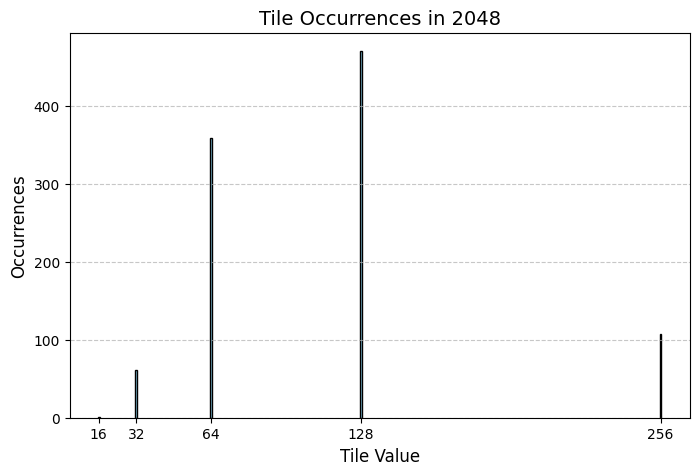

In [144]:
plot_graph(trail_random_ai(DQL(), 1000))